# 라이브러리 임포트

In [4]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

# 데이터 로딩

In [5]:
# raw data 로딩 
raw_data = pd.read_csv('/content/drive/MyDrive/Dongwon_Project/예측 과제/intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [6]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
copy_data = raw_data[['H_YMD', 'O_YMD', 'ORD_QTY', 'GOODS_NO', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

copy_data.fillna(0, inplace=True)
copy_data

,H_YMD,O_YMD,ORD_QTY,GOODS_NO,CANCEL_QTY,RET_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,REAL_ORD_QTY
166288,2020-01-01 00:00:00,2019-12-30 21:59:40,1,14375,0,0,8600,1408.00,7192,1
37753,2020-01-01 00:00:00,2019-12-30 20:50:07,2,1901012353,0,0,6300,0.00,6300,2
162585,2020-01-01 00:00:00,2019-12-30 11:02:39,1,1823,0,0,3300,486.00,2814,1
164041,2020-01-01 00:00:00,2019-12-30 15:19:58,1,1712010310,0,0,6900,264.00,6636,1
164040,2020-01-01 00:00:00,2019-12-30 10:08:58,1,1712010310,0,0,6900,317.00,6583,1
...,...,...,...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,2022-05-25 03:16:34,1,1803010879,0,0,4500,0.00,4500,1
241774,2022-05-31 00:00:00,2022-05-30 15:48:24,1,1909013359,0,0,9900,1801.00,8099,1
236656,2022-05-31 00:00:00,2022-05-29 15:45:30,1,1803010879,0,0,4500,0.00,4500,1
241810,2022-05-31 00:00:00,2022-05-30 15:54:40,1,1909013359,0,0,9900,1490.00,8410,1


# Feature Engineering

In [7]:
def SETTING(df):
  df['H_YMD'] = pd.to_datetime(df['H_YMD'])
  df['O_YMD'] = pd.to_datetime(df['O_YMD'])
  df['O_YMD'] = df['O_YMD'].dt.weekday

  df = df.groupby(['H_YMD', 'O_YMD'], as_index=False)
  df = df.agg({
                          'SALE_PRICE':['mean'], 
                          'ORD_QTY':['sum'],
                          'REAL_ORD_QTY':['sum'],
                          'CANCEL_QTY':['sum'],
                          'RET_QTY':['sum'],
                          'DISCOUNT_AMT':['sum'],
                          'FINAL_PRICE':['mean']
                          })

  df.columns = [       
                      'H_YMD', 'O_YMD',
                      'SALE_PRICE',
                      'ORD_QTY',
                      'REAL_ORD_QTY',
                      'CANCEL_QTY',
                      'RET_QTY',
                      'DISCOUNT_AMT',
                      'FINAL_PRICE'
                      ]

  
  return df

In [8]:
def ADD_DATETIME(df):
    # 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

    df['H_YMD'] = pd.to_datetime(df['H_YMD'])

    df['year'] = df['H_YMD'].dt.year
    df['month'] = df['H_YMD'].dt.month
    df['day'] = df['H_YMD'].dt.day

    return df

In [9]:
def ROLLING(df):
    # 몇개의 데이터를 가지고 연산을 할 것인가
    # 데이터들을 순차적으로 6일 (window=6)씩 선택해서 mean처럼 이동평균을 냄

    f_min = lambda x: x.rolling(window=2).min()
    # Max value
    f_max = lambda x: x.rolling(window=2).max()
    # Mean value
    f_mean = lambda x: x.rolling(window=2).mean()
    # Standard deviation
    f_std = lambda x: x.rolling(window=2).std()

    function_list = [f_min, f_max, f_mean, f_std]
    function_name = ['min', 'max', 'mean', 'std']
    #col = ['CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'LAST_REAL_ORD_QTY']
    col = ['REAL_ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE']

    for c in col:
        for i in range(len(function_list)):
            #df[('ORD_QTY_shifted_%s' % function_name[i])] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['REAL_ORD_QTY'].apply(function_list[i])
            df[('%s_shifted_%s' % (c, function_name[i]))] = df.groupby(by=['H_YMD'])[[c]].apply(function_list[i])
            # Fill the empty std features with 0
            df['%s_shifted_%s' % (c, function_name[i])].fillna(method='bfill', inplace=True)
    
    return df

In [10]:
def MERGE(df):
  last_roq = df.groupby(['H_YMD', 'O_YMD'])[['REAL_ORD_QTY']].sum()
  last_roq.rename(columns = {"REAL_ORD_QTY": "LAST_REAL_ORD_QTY"}, inplace=True)

  df['H_YMD'] += datetime.timedelta(days = 7)
  df1 = df.copy()
  df1.set_index('H_YMD', inplace=True)
  df2 = pd.merge(df1, last_roq, on=['H_YMD', 'O_YMD'],  how='inner')
  df2.reset_index(inplace=True)

  return df2


In [11]:
def LAG(df):
    # 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

    lag_list = [1,2,3,4,5,6]
    col = ['ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']

    for c in col:
        for lag in lag_list:
            ft_name = ('%s%s' % (c, lag))
            #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
            df[ft_name] = df.sort_values('H_YMD').groupby(['O_YMD'], as_index=True)[c].shift(lag)
            # Fill the empty shifted features with 0
            df[ft_name].fillna(0, inplace=True)

    return df

In [12]:
def TREND(df):
    # lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.
    lag_list = [1,2,3,4,5,6]
    df['item_trend'] = df['REAL_ORD_QTY']

    for lag in lag_list:
        ft_name = ('REAL_ORD_QTY%s' % lag)
        df['item_trend'] -= df[ft_name]

    df['item_trend'] /= len(lag_list) + 1

    return df

In [13]:
def MEAN_DATA(df):
    #df['Date'] = pd.DatetimeIndex(df['H_YMD']).date
    
    # 학습데이터의 상품번호 별 일별 판매량 평균
    gp_goods_mean = df.groupby(['H_YMD', 'O_YMD'], as_index=True).agg({'REAL_ORD_QTY': ['mean']})
    gp_goods_mean.columns = ['GOODS_mean']
    gp_goods_mean.reset_index(inplace=True)

    # 핛습데이터의 연도별 일별 판매량 평균
    gp_year_mean = df.groupby(['year']).agg({'REAL_ORD_QTY': ['mean']})
    gp_year_mean.columns = ['year_mean']
    gp_year_mean.reset_index(inplace=True)

    # 학습데이터의 월별 일별 판매량 평균
    gp_month_mean = df.groupby(['month']).agg({'REAL_ORD_QTY': ['mean']})
    gp_month_mean.columns = ['month_mean']
    gp_month_mean.reset_index(inplace=True)

    #df.rename(columns = {'Date':'H_YMD'}, inplace=True)

    # 훈련 데이터에 판매량 평균 데이터들 결함
    df = pd.merge(df, gp_goods_mean, on=['H_YMD','O_YMD'], how='left')
    df = pd.merge(df, gp_year_mean, on=['year'], how='left')
    df = pd.merge(df, gp_month_mean, on=['month'], how='left')

    return df

In [14]:
# 결측치들을 상품번호별 중앙값으로 대체한다.

def REPLACE_MISSING_VALUE(df):
    #Replace missing values with the median of each shop.            
    # for goods_no in df['GOODS_NO'].unique():
    #     #print('goods_no: ', goods_no)
    #     for column in df.columns:
    #         goods_median = df[(df['GOODS_NO'] == goods_no)][column].median()
    #         df.loc[(df[column].isnull()) & (df['GOODS_NO'] == goods_no), column] = goods_median

    # Fill remaining missing values on test set with mean.
    df.fillna(df.mean(), inplace=True)


    return df 

In [15]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [17]:
from pandas.core.common import temp_setattr
def DBC_PIPELINE(df):
    temp = df.copy()

    print('--------------------------- [Goods Choice] ----------------------------\n'
        '1. 두메산나물비빔밥재료\n',
        '2. 옛날잡채(500g)\n',
        '3. 채소계란찜(340g)\n',
        '4. 셀프두부조림(600g)\n',
        '5. 수제계란말이(350g)\n',
        '6. 메밀소바(2인분)\n',
        '7. 고소한도토리묵무침(360g)\n',
        '8. 한돈 제육볶음(700g)\n',
        '9. 소고기유니짜장소스(1인분, 200g)\n',
        '10.숙주나물(300g)\n',
        '11.건표고버섯볶음\n',
        '12.양장피\n',
        '13.꼬막무침 (260g)\n',
        '14.순살코다리강정(180g)\n',
        '15.우삼겹숙주볶음(250g)\n',
        '16.열무비빔밥재료믹스(2인분)\n',
        '17.[심방골주부X더반찬] 시골 돼지짜글이(600g)\n',
        '18.고구마 품은 라자냐(450g)\n',
        '19.고사리나물볶음(150g)\n',
        '20.가정집 오징어불고기/셀프(380g)\n'
        '-----------------------------------------------------------------------\n')
    num = int(input('상품 번호를 입력하세요: '))
    print()
    
    gn = list(GOODS_DIC.keys())[num-1]

    temp = temp[temp['GOODS_NO'] == gn]

    temp = SETTING(temp)

    temp = ROLLING(temp)

    temp = MERGE(temp)

    temp = ADD_DATETIME(temp)

    temp = LAG(temp)
    
    temp = TREND(temp)

    temp = MEAN_DATA(temp)

    temp = REPLACE_MISSING_VALUE(temp)

    return temp

In [49]:
df = copy_data.copy()

In [50]:
my_data = DBC_PIPELINE(df)
my_data

--------------------------- [Goods Choice] ----------------------------
1. 두메산나물비빔밥재료
 2. 옛날잡채(500g)
 3. 채소계란찜(340g)
 4. 셀프두부조림(600g)
 5. 수제계란말이(350g)
 6. 메밀소바(2인분)
 7. 고소한도토리묵무침(360g)
 8. 한돈 제육볶음(700g)
 9. 소고기유니짜장소스(1인분, 200g)
 10.숙주나물(300g)
 11.건표고버섯볶음
 12.양장피
 13.꼬막무침 (260g)
 14.순살코다리강정(180g)
 15.우삼겹숙주볶음(250g)
 16.열무비빔밥재료믹스(2인분)
 17.[심방골주부X더반찬] 시골 돼지짜글이(600g)
 18.고구마 품은 라자냐(450g)
 19.고사리나물볶음(150g)
 20.가정집 오징어불고기/셀프(380g)
-----------------------------------------------------------------------

상품 번호를 입력하세요: 4



,H_YMD,O_YMD,SALE_PRICE,ORD_QTY,REAL_ORD_QTY,CANCEL_QTY,RET_QTY,DISCOUNT_AMT,FINAL_PRICE,REAL_ORD_QTY_shifted_min,...,REAL_ORD_QTY1,REAL_ORD_QTY2,REAL_ORD_QTY3,REAL_ORD_QTY4,REAL_ORD_QTY5,REAL_ORD_QTY6,item_trend,GOODS_mean,year_mean,month_mean
0,2020-01-08,0,4900.00,14,11,3,0,1080.00,4822.86,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.57,11.00,12.58,13.84
1,2020-01-08,1,4900.00,2,2,0,0,214.00,4793.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.29,2.00,12.58,13.84
2,2020-01-09,0,4900.00,7,7,0,0,1595.00,4672.14,7.00,...,11.00,0.00,0.00,0.00,0.00,0.00,-0.57,7.00,12.58,13.84
3,2020-01-09,1,4900.00,44,34,10,0,3700.00,4731.82,7.00,...,2.00,0.00,0.00,0.00,0.00,0.00,4.57,34.00,12.58,13.84
4,2020-01-09,2,4900.00,5,5,0,0,477.00,4804.60,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.71,5.00,12.58,13.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3478,2022-05-31,0,4900.00,51,46,5,0,16244.00,4554.38,2.00,...,1.00,2.00,23.00,47.00,1.00,1.00,-4.14,46.00,18.37,13.44
3479,2022-05-31,3,4900.00,3,2,1,0,5067.00,3211.00,2.00,...,7.00,24.00,35.00,3.00,1.00,7.00,-10.71,2.00,18.37,13.44
3480,2022-05-31,4,4900.00,4,4,0,0,2168.00,4358.00,2.00,...,20.00,36.00,1.00,2.00,18.00,45.00,-16.86,4.00,18.37,13.44
3481,2022-05-31,5,4900.00,4,4,0,0,818.00,4695.50,4.00,...,30.00,6.00,4.00,23.00,2.00,9.00,-10.00,4.00,18.37,13.44


In [ ]:
my_data.to_csv('/content/drive/MyDrive/Dongwon_Project/예측 과제/my_data.csv', encoding='utf-8-sig')

# 데이터 정형화

In [51]:
from sklearn.model_selection import train_test_split

my_data['H_YMD'] = pd.to_datetime(my_data['H_YMD'])

test_set =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx = my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
my_data.drop(idx, inplace=True)

target = 'LAST_REAL_ORD_QTY'

Y = my_data[target]
X = my_data.drop(target, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=.2, shuffle=False, random_state=2022 )
y_test = test_set[target]
X_test = test_set.drop(target, axis=1)

In [52]:
train = X_train['H_YMD']
val = X_val['H_YMD']
test = X_test['H_YMD']

In [37]:
my_data.columns

Index(['H_YMD', 'O_YMD', 'SALE_PRICE', 'ORD_QTY', 'REAL_ORD_QTY', 'CANCEL_QTY',
       'RET_QTY', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY_shifted_min',
       'REAL_ORD_QTY_shifted_max', 'REAL_ORD_QTY_shifted_mean',
       'REAL_ORD_QTY_shifted_std', 'CANCEL_QTY_shifted_min',
       'CANCEL_QTY_shifted_max', 'CANCEL_QTY_shifted_mean',
       'CANCEL_QTY_shifted_std', 'RET_QTY_shifted_min', 'RET_QTY_shifted_max',
       'RET_QTY_shifted_mean', 'RET_QTY_shifted_std', 'SALE_PRICE_shifted_min',
       'SALE_PRICE_shifted_max', 'SALE_PRICE_shifted_mean',
       'SALE_PRICE_shifted_std', 'DISCOUNT_AMT_shifted_min',
       'DISCOUNT_AMT_shifted_max', 'DISCOUNT_AMT_shifted_mean',
       'DISCOUNT_AMT_shifted_std', 'FINAL_PRICE_shifted_min',
       'FINAL_PRICE_shifted_max', 'FINAL_PRICE_shifted_mean',
       'FINAL_PRICE_shifted_std', 'LAST_REAL_ORD_QTY', 'year', 'month', 'day',
       'ORD_QTY1', 'ORD_QTY2', 'ORD_QTY3', 'ORD_QTY4', 'ORD_QTY5', 'ORD_QTY6',
       'CANCEL_QTY1', 'CANCEL_QT

In [53]:
corr = my_data[[
    'REAL_ORD_QTY', 'CANCEL_QTY',
       'RET_QTY', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY_shifted_min',
       'REAL_ORD_QTY_shifted_max', 'REAL_ORD_QTY_shifted_mean',
       'REAL_ORD_QTY_shifted_std', 'CANCEL_QTY_shifted_min',
       'CANCEL_QTY_shifted_max', 'CANCEL_QTY_shifted_mean',
       'CANCEL_QTY_shifted_std', 'RET_QTY_shifted_min', 'RET_QTY_shifted_max',
       'RET_QTY_shifted_mean', 'RET_QTY_shifted_std', 'SALE_PRICE_shifted_min',
       'SALE_PRICE_shifted_max', 'SALE_PRICE_shifted_mean',
       'SALE_PRICE_shifted_std', 'DISCOUNT_AMT_shifted_min',
       'DISCOUNT_AMT_shifted_max', 'DISCOUNT_AMT_shifted_mean',
       'DISCOUNT_AMT_shifted_std', 'FINAL_PRICE_shifted_min',
       'FINAL_PRICE_shifted_max', 'FINAL_PRICE_shifted_mean',
       'FINAL_PRICE_shifted_std', 'LAST_REAL_ORD_QTY', 'year', 'month', 'day',
       'ORD_QTY1', 'ORD_QTY2', 'ORD_QTY3', 'ORD_QTY4', 'ORD_QTY5', 'ORD_QTY6',
       'CANCEL_QTY1', 'CANCEL_QTY2', 'CANCEL_QTY3', 'CANCEL_QTY4',
       'CANCEL_QTY5', 'CANCEL_QTY6', 'RET_QTY1', 'RET_QTY2', 'RET_QTY3',
       'RET_QTY4', 'RET_QTY5', 'RET_QTY6', 'SALE_PRICE1', 'SALE_PRICE2',
       'SALE_PRICE3', 'SALE_PRICE4', 'SALE_PRICE5', 'SALE_PRICE6',
       'DISCOUNT_AMT1', 'DISCOUNT_AMT2', 'DISCOUNT_AMT3', 'DISCOUNT_AMT4',
       'DISCOUNT_AMT5', 'DISCOUNT_AMT6', 'FINAL_PRICE1', 'FINAL_PRICE2',
       'FINAL_PRICE3', 'FINAL_PRICE4', 'FINAL_PRICE5', 'FINAL_PRICE6',
       'REAL_ORD_QTY1', 'REAL_ORD_QTY2', 'REAL_ORD_QTY3', 'REAL_ORD_QTY4',
       'REAL_ORD_QTY5', 'REAL_ORD_QTY6', 'item_trend', 'GOODS_mean',
       'year_mean', 'month_mean'
]]

# plt.figure(figsize=(20,20))
# sns.heatmap(corr.corr(),annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [54]:
corr.corr()['LAST_REAL_ORD_QTY'].sort_values(ascending=False)

LAST_REAL_ORD_QTY            1.00
REAL_ORD_QTY                 0.81
GOODS_mean                   0.81
REAL_ORD_QTY_shifted_mean    0.68
REAL_ORD_QTY_shifted_max     0.65
                             ... 
FINAL_PRICE_shifted_std     -0.13
CANCEL_QTY2                 -0.17
DISCOUNT_AMT2               -0.23
REAL_ORD_QTY2               -0.41
ORD_QTY2                    -0.41
Name: LAST_REAL_ORD_QTY, Length: 79, dtype: float64

In [55]:
features = [
        'ORD_QTY', 'REAL_ORD_QTY', 'CANCEL_QTY',
       'RET_QTY', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY_shifted_min',
       'REAL_ORD_QTY_shifted_max', 'REAL_ORD_QTY_shifted_mean',
       'REAL_ORD_QTY_shifted_std', 
       'CANCEL_QTY_shifted_max', 'CANCEL_QTY_shifted_mean',
       'CANCEL_QTY_shifted_std', 'RET_QTY_shifted_min', 'RET_QTY_shifted_max',
       'RET_QTY_shifted_mean', 'RET_QTY_shifted_std', 'SALE_PRICE_shifted_min',
       'SALE_PRICE_shifted_max', 'SALE_PRICE_shifted_mean',
       'SALE_PRICE_shifted_std', 'DISCOUNT_AMT_shifted_min',
       'DISCOUNT_AMT_shifted_max', 'DISCOUNT_AMT_shifted_mean',
       'DISCOUNT_AMT_shifted_std', 'FINAL_PRICE_shifted_mean',
       'FINAL_PRICE_shifted_std', 
       'ORD_QTY1', 'ORD_QTY2', 'ORD_QTY3', 'CANCEL_QTY1', 'CANCEL_QTY2',
       'CANCEL_QTY3', 'RET_QTY1', 'RET_QTY2', 'SALE_PRICE1',
       'DISCOUNT_AMT1', 'DISCOUNT_AMT2',
       'DISCOUNT_AMT3', 'FINAL_PRICE1',
       'REAL_ORD_QTY1', 'REAL_ORD_QTY2', 'REAL_ORD_QTY3', 'item_trend',
       'GOODS_mean', 'month_mean'
            ]

features2 = [
        'REAL_ORD_QTY', 'CANCEL_QTY',
       'RET_QTY', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY_shifted_min',
       'REAL_ORD_QTY_shifted_max', 'REAL_ORD_QTY_shifted_mean',
       'REAL_ORD_QTY_shifted_std', 'CANCEL_QTY_shifted_min',
       'CANCEL_QTY_shifted_max', 'CANCEL_QTY_shifted_mean',
       'CANCEL_QTY_shifted_std', 'RET_QTY_shifted_min', 'RET_QTY_shifted_max',
       'RET_QTY_shifted_mean', 'RET_QTY_shifted_std', 'SALE_PRICE_shifted_min',
       'SALE_PRICE_shifted_max', 'SALE_PRICE_shifted_mean',
       'SALE_PRICE_shifted_std', 'DISCOUNT_AMT_shifted_min',
       'DISCOUNT_AMT_shifted_max', 'DISCOUNT_AMT_shifted_mean',
       'DISCOUNT_AMT_shifted_std', 'FINAL_PRICE_shifted_min',
       'FINAL_PRICE_shifted_max', 'FINAL_PRICE_shifted_mean',
       'FINAL_PRICE_shifted_std', 'year', 'month', 'day',
       'ORD_QTY1', 'ORD_QTY2', 'ORD_QTY3', 'ORD_QTY4', 'ORD_QTY5', 'ORD_QTY6',
       'CANCEL_QTY1', 'CANCEL_QTY2', 'CANCEL_QTY3', 'CANCEL_QTY4',
       'CANCEL_QTY5', 'CANCEL_QTY6', 'RET_QTY1', 'RET_QTY2', 'RET_QTY3',
       'RET_QTY4', 'RET_QTY5', 'RET_QTY6', 'SALE_PRICE1', 'SALE_PRICE2',
       'SALE_PRICE3', 'SALE_PRICE4', 'SALE_PRICE5', 'SALE_PRICE6',
       'DISCOUNT_AMT1', 'DISCOUNT_AMT2', 'DISCOUNT_AMT3', 'DISCOUNT_AMT4',
       'DISCOUNT_AMT5', 'DISCOUNT_AMT6', 'FINAL_PRICE1', 'FINAL_PRICE2',
       'FINAL_PRICE3', 'FINAL_PRICE4', 'FINAL_PRICE5', 'FINAL_PRICE6',
       'REAL_ORD_QTY1', 'REAL_ORD_QTY2', 'REAL_ORD_QTY3', 'REAL_ORD_QTY4',
       'REAL_ORD_QTY5', 'REAL_ORD_QTY6', 'item_trend', 'GOODS_mean',
       'year_mean', 'month_mean'
       ]

# 모델링

In [ ]:
X_train

,H_YMD,O_YMD,SALE_PRICE,ORD_QTY,REAL_ORD_QTY,CANCEL_QTY,RET_QTY,DISCOUNT_AMT,FINAL_PRICE,REAL_ORD_QTY_shifted_min,...,FINAL_PRICE1,FINAL_PRICE2,FINAL_PRICE3,REAL_ORD_QTY1,REAL_ORD_QTY2,REAL_ORD_QTY3,item_trend,GOODS_mean,year_mean,month_mean
0,2020-01-08,0,8600.00,49,48,1,0,17656.00,8189.40,22.00,...,0.00,0.00,0.00,0.00,0.00,0.00,12.00,48.00,24.44,29.44
1,2020-01-08,1,8600.00,22,22,0,0,5153.00,8342.35,22.00,...,0.00,0.00,0.00,0.00,0.00,0.00,5.50,22.00,24.44,29.44
2,2020-01-08,2,8600.00,2,2,0,0,0.00,8600.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.50,2.00,24.44,29.44
3,2020-01-08,3,8600.00,5,5,0,0,0.00,8600.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.25,5.00,24.44,29.44
4,2020-01-08,4,8600.00,7,7,0,0,1686.00,8262.80,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.75,7.00,24.44,29.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,2021-11-10,5,8800.00,3,3,0,0,1281.00,8373.00,2.00,...,8141.08,8118.43,7083.67,12.00,53.00,3.00,-16.25,3.00,26.91,24.28
3475,2021-11-10,6,8800.00,5,5,0,0,1115.00,8577.00,3.00,...,8555.57,7679.12,6935.00,41.00,42.00,4.00,-20.50,5.00,26.91,24.28
3476,2021-11-11,0,8800.00,16,16,0,0,1667.00,8671.77,16.00,...,8528.67,8581.21,7766.88,50.00,51.00,7.00,-23.00,16.00,26.91,24.28
3477,2021-11-11,1,8800.00,173,167,6,1,156338.00,7486.24,16.00,...,6310.81,8800.00,7010.67,141.00,1.00,3.00,5.50,167.00,26.91,24.28


In [25]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

In [56]:
X_train = X_train[features2]
X_val = X_val[features2]
X_test = X_test[features2]

In [ ]:
# 학습, 검증, 테스트 데이터 로그화
X_train_l = np.log1p(X_train)
X_val_l = np.log1p(X_val)
X_test_l = np.log1p(X_test)

y_train_l = np.log1p(y_train)
y_val_l = np.log1p(y_val)
y_test_l = np.log1p(y_test)

In [ ]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [57]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge()      # best alpha = 0
lasso_reg = Lasso()        # best alpha = 1
tree_reg = DecisionTreeRegressor()
xgb_reg = XGBRegressor()
forest_reg = RandomForestRegressor()
lgbm_reg = LGBMRegressor(objective='regression')

for model in [ridge_reg, lasso_reg, tree_reg, xgb_reg, forest_reg, lgbm_reg]:
# for model in [forest_reg]:
    #get_model_predict(model, X_train, X_val, y_train, y_val)
    get_model_predict(model, X_train, X_val, y_train, y_val)

### Ridge ###
RMSE : 8.34009 | MAE : 5.8924 | r2 : 0.75321 
### Lasso ###
RMSE : 8.35701 | MAE : 5.67168 | r2 : 0.7522 
### DecisionTreeRegressor ###
RMSE : 14.55455 | MAE : 9.00297 | r2 : 0.24839 
[02:24:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSE : 8.79319 | MAE : 5.69323 | r2 : 0.72566 
### RandomForestRegressor ###
RMSE : 8.99216 | MAE : 6.05614 | r2 : 0.71311 
### LGBMRegressor ###
RMSE : 9.14991 | MAE : 5.96677 | r2 : 0.70295 


In [58]:
pd.DataFrame([X_train.columns, ridge_reg.coef_]).T.sort_values(by=1, ascending=False)

,0,1
16,RET_QTY_shifted_std,0.99
2,RET_QTY,0.62
44,RET_QTY1,0.47
0,REAL_ORD_QTY,0.36
75,GOODS_mean,0.36
...,...,...
42,CANCEL_QTY5,-0.22
9,CANCEL_QTY_shifted_min,-0.41
45,RET_QTY2,-0.52
15,RET_QTY_shifted_mean,-0.79


#릿지 하이퍼 파라미터 튜닝

In [ ]:
ridge_reg = Ridge()
pipe = make_pipeline(ridge_reg)
scores = cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('ridge MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

ridge MSLE: 611.710


In [ ]:
red_pipeline = Pipeline([('ridge', Ridge())])
red_params = {'ridge__alpha':[0, 1, 2, 3, 4, 5, 10, 15, 20]}
red_grid_model = GridSearchCV(red_pipeline, param_grid=red_params, scoring='neg_mean_squared_error', cv=5)
red_grid_model.fit(X_train, y_train)
print('MLSE: {0:.3f}'.format( -1*red_grid_model.best_score_))
print('optimal hyperparameter: ',  red_grid_model.best_params_)

MLSE: 610.340
optimal hyperparameter:  {'ridge__alpha': 20}


In [ ]:
red_pred = red_grid_model.predict(X_test)
print('r2: ', r2_score(y_test, red_pred))

r2:  0.6314324775379796


In [ ]:
test

0     2022-05-02
1     2022-05-02
2     2022-05-02
3     2022-05-02
4     2022-05-02
         ...    
139   2022-05-31
140   2022-05-31
141   2022-05-31
142   2022-05-31
143   2022-05-31
Name: H_YMD, Length: 144, dtype: datetime64[ns]

In [ ]:
y_test

4349     1
4350     1
4351     9
4352    31
4353    54
        ..
4488     2
4489     1
4490     2
4491    14
4492    46
Name: LAST_REAL_ORD_QTY, Length: 144, dtype: int64

In [ ]:
red_pred

array([ 1.39770468e+00, -9.71412980e-01,  2.16751842e+01,  2.36908107e+01,
        2.53971232e+01,  4.24777027e+01,  6.00037500e+01,  1.73312667e+00,
        5.99528590e-01,  7.87403616e+00,  1.18951543e+01,  3.35201609e+01,
        3.41843700e+01,  6.30119188e+01,  1.16534191e+01,  7.54775135e+00,
        4.14245403e+00,  1.18383794e+01,  1.14397923e+01,  4.89022817e+01,
        6.35819265e+01,  9.79325339e+00,  6.58355214e+00,  3.43472790e+00,
        1.85230782e+01,  4.84465189e+01,  5.26372515e+01,  6.01244015e+00,
        7.08186307e+00,  8.74892616e+00,  7.88378851e+00,  1.28024098e+01,
        1.92496937e+01,  7.06424016e+01,  5.21869448e+01,  1.06993417e+01,
        3.08618099e+00,  9.93606299e-01,  1.58503082e+01,  3.14861645e+01,
        4.95650587e+01,  4.20244865e+01,  4.58333287e+01,  6.53907784e+00,
        1.41638069e+01,  1.32363961e+01,  3.65098245e+01,  4.02094454e+01,
        6.92753038e+01,  5.55523496e-02,  9.08291571e+00,  1.78419032e+01,
        1.20073821e+01,  

In [ ]:
joblib.dump(red_grid_model, 'red_grid_model.pkl')

['red_grid_model.pkl']

# 랜덤포레스트 하이퍼 파라미터 튜닝

In [ ]:
np.random.seed(0)
rf = RandomForestRegressor(n_estimators=500)
pipe = make_pipeline(MinMaxScaler(), rf)
scores =  cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('rf MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

rf MSLE: 686.288


In [ ]:
rf_pipeline = Pipeline([('rf', RandomForestRegressor())])
rf_params = {'rf__max_depth': [5, 10 , None],
             'rf__min_samples_leaf': [1, 3],
             'rf__min_samples_split':[2, 3],
             'rf__n_estimators':[500, 1000]}
rf_grid_model = GridSearchCV(rf_pipeline, param_grid=rf_params, scoring='neg_mean_squared_error', cv=5,
                            n_jobs=5, verbose=True)
rf_grid_model.fit(X_train, y_train)
print('rf MLSE: {0:.3f}'.format( -1*rf_grid_model.best_score_))
print('rf optimal hyperparameter: ',  rf_grid_model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
rf MLSE: 452.926
rf optimal hyperparameter:  {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3, 'rf__n_estimators': 500}


In [ ]:
rf_pred = rf_grid_model.predict(X_val)
print('r2: ', r2_score(y_val, rf_pred))

r2:  0.5817033402919292


In [47]:
rf_model = RandomForestRegressor(max_depth=10,
                                  min_samples_leaf=3,
                                  min_samples_split=3,
                                  n_estimators=500)
rf_model.fit(X_train, y_train)
rf_test_pred = rf_model.predict(X_test)
print('r2: ', r2_score(y_test, rf_test_pred))

r2:  0.6986133603854534


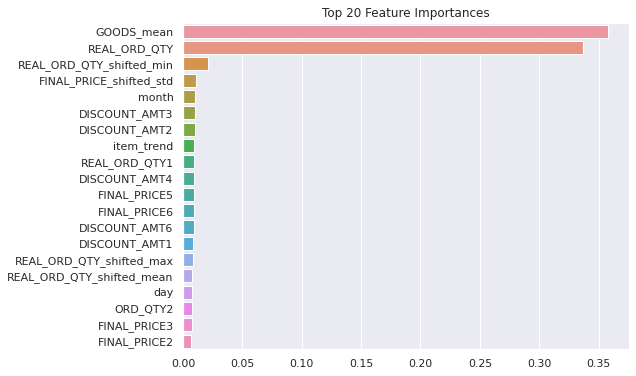

In [48]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
joblib.dump(rf_grid_model, '/content/drive/MyDrive/Dongwon_Project/예측 과제/models/rf_grid_model.pkl')

['/content/drive/MyDrive/Dongwon_Project/예측 과제/models/rf_grid_model.pkl']

In [ ]:
joblib.dump(rf_model, '/content/drive/MyDrive/Dongwon_Project/예측 과제/models/rf_model.pkl')

['/content/drive/MyDrive/Dongwon_Project/예측 과제/models/rf_model.pkl']

# LGBM 하이퍼 파라미터 튜닝

In [ ]:
lgbm = LGBMRegressor(n_estimators=500, objective='regression')
pipe = make_pipeline(lgbm)
scores =  cross_validate(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('lgbm MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

lgbm MSLE: 612.125


In [ ]:
lgbm_pipeline = Pipeline([('lgbm', LGBMRegressor(objective='regression'))])
lgbm_params = {'lgbm__learning_rate':[0.001, 0.01, 0.1],
               'lgbm__max_depth': [3, 5, 10],
               'lgbm__reg_lambda':[0.1, 0.5, 1, 1.5],
               'lgbm__subsample': [0.5, 0.75, 1],
               'lgbm__n_estimators': [500, 1000]}
lgbm_grid_model = GridSearchCV(lgbm_pipeline, param_grid=lgbm_params, scoring='neg_mean_squared_error',
                               cv=5, n_jobs=5, verbose=True)
lgbm_grid_model.fit(X_train, y_train)
print('lgbm MLSE: {0:.3f}'.format( -1*lgbm_grid_model.best_score_))
print('lgbm optimal hyperparameter: ',  lgbm_grid_model.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
lgbm MLSE: 488.978
lgbm optimal hyperparameter:  {'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 3, 'lgbm__n_estimators': 500, 'lgbm__reg_lambda': 1.5, 'lgbm__subsample': 0.5}


In [ ]:
lgbm_pred = lgbm_grid_model.predict(X_val)
print('r2: ', r2_score(y_val, lgbm_pred))

r2:  0.5185588005965646


In [59]:
lgbm_model = LGBMRegressor(learning_rate=0.01,
                           max_depth=3,
                           n_estimators=500,
                           reg_lambda=1.5,
                           subsample=0.5)
lgbm_model.fit(X_train, y_train)
lgbm_test_pred = lgbm_model.predict(X_test)
print('r2: ', r2_score(y_test, lgbm_test_pred))

r2:  0.7206854576367906


In [ ]:
joblib.dump(lgbm_grid_model, '/content/drive/MyDrive/Dongwon_Project/예측 과제/models/lgbm_grid_model.pkl')

['/content/drive/MyDrive/Dongwon_Project/예측 과제/models/lgbm_grid_model.pkl']

In [ ]:
joblib.dump(lgbm_model, '/content/drive/MyDrive/Dongwon_Project/예측 과제/models/lgbm_test_model.pkl')

['/content/drive/MyDrive/Dongwon_Project/예측 과제/models/lgbm_test_model.pkl']

# XGBoost 하이퍼 파라미터 튜닝

In [ ]:
xgb = XGBRegressor()
pipe = make_pipeline(xgb)
scores =  cross_validate(pipe, X_train_l, y_train_l, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print('xgb MSLE: {0:.3f}'.format(np.mean(-scores['test_score'])))

[02:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb MSLE: 0.140


In [ ]:
xgb_pipeline = Pipeline([('xgb', XGBRegressor())])
xgb_params={
    'xgb__n_estimators' : [500, 1000],
    'xgb__learning_rate' : [0.01,0.1],
    'xgb__max_depth' : [3,5,10],
    'xgb__gamma' : [0.5, 1, 1.5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree' : [0.6, 0.8, 1.0],
}
xgb_grid_model = GridSearchCV(xgb_pipeline, param_grid=xgb_params, scoring='neg_mean_squared_error',
                               cv=5, n_jobs=5, verbose=True)
xgb_grid_model.fit(X_train, y_train)
print('xgb MLSE: {0:.3f}'.format( -1*xgb_grid_model.best_score_))
print('xgb optimal hyperparameter: ',  xgb_grid_model.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[06:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb MLSE: 492.896
xgb optimal hyperparameter:  {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 1.5, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}


In [ ]:
xgb_pred = xgb_grid_model.predict(X_val)
print('r2: ', r2_score(y_val, xgb_pred))

r2:  0.4381976591848733


In [ ]:
xgb_pipeline2 = Pipeline([('xgb', XGBRegressor())])
xgb_params2 = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}
reg = XGBRegressor(nthread=-1)
xgb_random_model = RandomizedSearchCV(reg, param_distributions=xgb_params2,
                                   n_iter=100, cv=5, verbose=True, scoring='neg_mean_squared_error')
xgb_random_model.fit(X_train, y_train)
print('xgb MLSE: {0:.3f}'.format( -1*xgb_random_model.best_score_))
print('xgb optimal hyperparameter: ',  xgb_random_model.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
xgb MLSE: 448.010
xgb optimal hyperparameter:  {'subsample': 0.6, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.5, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


In [ ]:
xgb_pred2 = xgb_random_model.predict(X_val)
print('r2: ', r2_score(np.expm1(y_val_l), np.expm1(xgb_pred2)))

r2:  0.7676363827677724


In [ ]:
joblib.dump(xgb_grid_model, '/content/drive/MyDrive/Dongwon_Project/예측 과제/models/xgb_grid_model.pkl')

['/content/drive/MyDrive/Dongwon_Project/예측 과제/models/xgb_grid_model.pkl']

In [ ]:
xgb = joblib.load('/content/drive/MyDrive/Dongwon_Project/예측 과제/models/xgb_grid_model.pkl')

[00:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
xgb_model = XGBRegressor(learning_rate=0.01,
                         max_depth=3,
                         n_estimators=500,
                         gamma=1.5,
                         colsample_bytree=1.0,
                         subsample=1.0,
                         )
xgb_model.fit(X_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, y_train), (X_val, y_val)],
              early_stopping_rounds=30
              )

[02:25:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18.3796	validation_1-rmse:23.0818
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:18.2326	validation_1-rmse:22.8996
[2]	validation_0-rmse:18.0873	validation_1-rmse:22.7195
[3]	validation_0-rmse:17.9437	validation_1-rmse:22.5412
[4]	validation_0-rmse:17.8019	validation_1-rmse:22.365
[5]	validation_0-rmse:17.6617	validation_1-rmse:22.1906
[6]	validation_0-rmse:17.5233	validation_1-rmse:22.0183
[7]	validation_0-rmse:17.3865	validation_1-rmse:21.8478
[8]	validation_0-rmse:17.2514	validation_1-rmse:21.6793
[9]	validation_0-rmse:17.1179	validation_1-rmse:21.5125
[10]	validation_0-rmse:16.986	validation_1-rmse:21.3477
[11]	validation_0-rmse:16.8557	validation_1-rmse:21.1846
[12]	validation_0-rmse:16.727	validation_1

XGBRegressor(colsample_bytree=1.0, gamma=1.5, learning_rate=0.01,
             n_estimators=500, subsample=1.0)

In [61]:
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

In [62]:
xgb_test_pred

array([ 3.3412647,  7.822999 , 18.235218 , 20.054232 , 42.02385  ,
       32.12995  ,  4.657025 ,  6.5565205, 26.14556  , 28.401024 ,
       33.988613 ,  6.1582417,  5.3309665, 25.525867 , 32.940487 ,
        6.3807387,  3.945561 ,  5.788314 , 36.958424 , 46.875    ,
        3.2162082,  2.6511948,  4.040563 ,  8.490316 , 20.408657 ,
       38.597473 ,  5.3653955,  2.5430784,  7.9834814, 15.150049 ,
       21.188778 , 35.56387  , 33.76006  ,  3.6126456,  4.484334 ,
       28.958921 , 29.816755 , 27.34086  ,  2.4102588,  4.076876 ,
        3.8975537, 14.2551985, 23.27289  ,  2.4247503,  3.8053188,
       10.724618 , 33.98948  , 46.08041  ,  5.1641603,  5.6827865,
        8.33146  , 22.683628 , 30.27708  ,  5.222091 ,  3.011893 ,
        3.177551 ,  4.7373514, 17.651121 , 16.466038 , 28.269323 ,
       31.80384  ,  2.374012 ,  3.952544 ,  9.73214  , 30.48807  ,
       36.323673 , 34.88874  ,  4.550794 ,  3.1656218,  4.2833805,
        4.592773 , 28.929836 , 28.01555  ,  2.5050821,  2.2190

In [63]:
y_test

3364     2
3365     4
3366    14
3367    24
3368    47
        ..
3478    47
3479     1
3480     4
3481     4
3482    18
Name: LAST_REAL_ORD_QTY, Length: 119, dtype: int64

In [64]:
print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.7277701132509069
Train rmse: 7.173353581509717
Validation rmse: 8.632471024998285


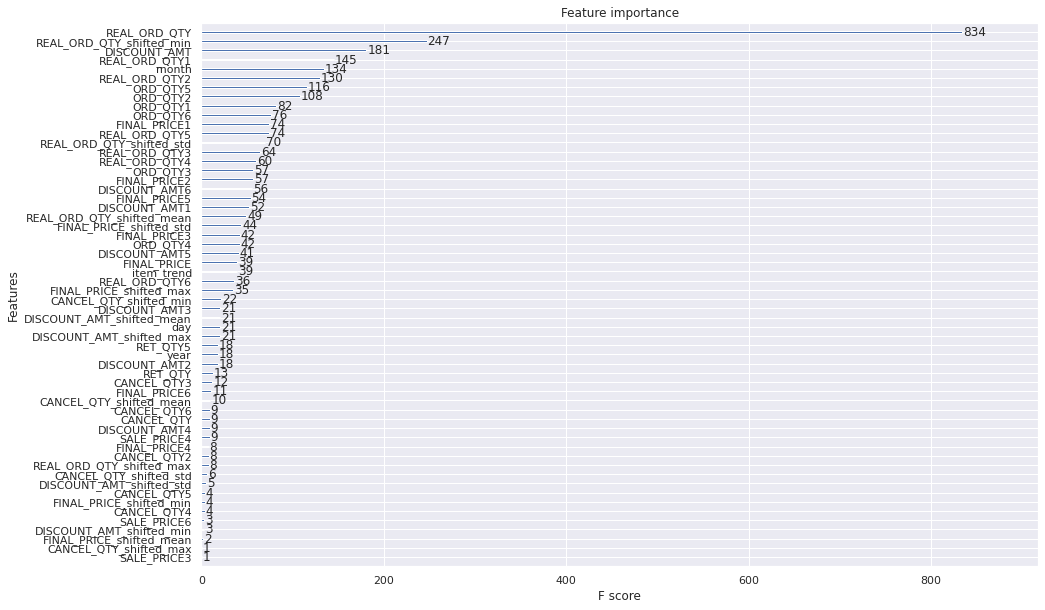

In [65]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(xgb_model)
plt.show()

# 결과 저장

In [37]:
def to_csv(predict, x_test, y_test):
    x_test.reset_index(drop=True, inplace=True)
    predict = pd.DataFrame(predict)
    predict['H_YMD'] = x_test
    
    y_test = pd.DataFrame(y_test)
    y_test.reset_index(drop=True, inplace=True)
    y_test['H_YMD'] = x_test
    
    predict.columns = ['REAL_ORD_QTY',  'H_YMD']
    y_test.columns = ['REAL_ORD_QTY',  'H_YMD']

    predict['H_YMD'] = pd.to_datetime(predict['H_YMD'])
    predict.sort_values(by = 'H_YMD', inplace=True)
    predict = predict.groupby(['H_YMD'])
    predict = predict.sum()

    y_test['H_YMD'] = pd.to_datetime(y_test['H_YMD'])
    y_test.sort_values(by = 'H_YMD', inplace=True)
    y_test = y_test.groupby(['H_YMD'])
    y_test = y_test.sum()

    print('r2:', r2_score(predict['REAL_ORD_QTY'], y_test['REAL_ORD_QTY']))

    plt.plot(y_test.index.date, y_test['REAL_ORD_QTY'], label='True')
    plt.plot(predict.index.date, predict['REAL_ORD_QTY'],label='Predict')
    plt.xlabel('Time', fontsize = 18)
    plt.ylabel('Real Ord Qty', fontsize = 18)
    plt.legend()
    
    return predict, y_test

r2: -2.0695898655871443


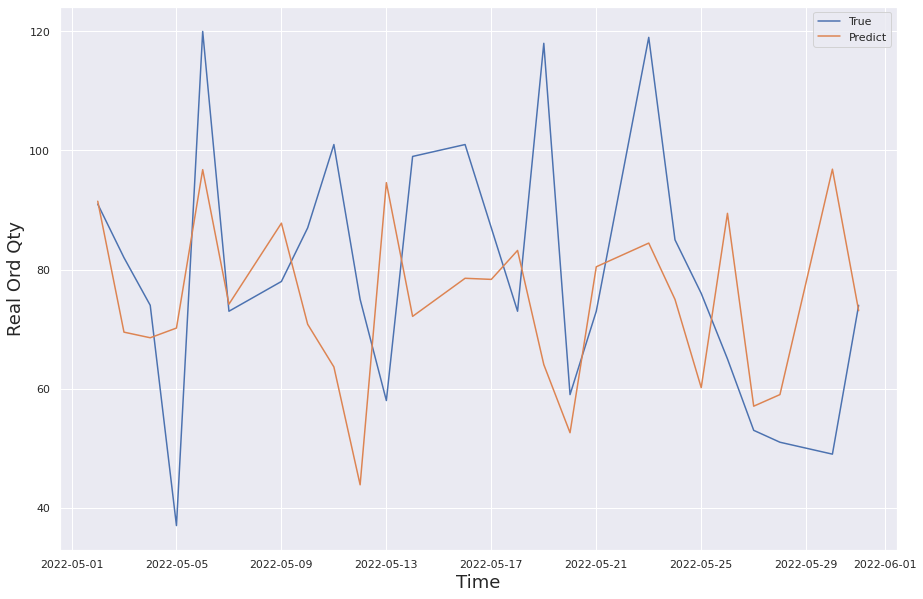

In [66]:
xgb_result, y_result = to_csv(xgb_test_pred, test, y_test)

y_result.to_csv('/content/drive/MyDrive/Dongwon_Project/예측 과제/results/y_result.csv', encoding='utf-8-sig')
xgb_result.to_csv('/content/drive/MyDrive/Dongwon_Project/예측 과제/results/xgb_result.csv', encoding='utf-8-sig')

In [67]:
xgb_result


,REAL_ORD_QTY
H_YMD,
2022-05-02,91.48
2022-05-03,69.49
2022-05-04,68.55
2022-05-05,70.18
2022-05-06,96.78
2022-05-07,74.19
2022-05-09,87.79
2022-05-10,70.82
2022-05-11,63.64


In [68]:
y_result

,REAL_ORD_QTY
H_YMD,
2022-05-02,91
2022-05-03,82
2022-05-04,74
2022-05-05,37
2022-05-06,120
2022-05-07,73
2022-05-09,78
2022-05-10,87
2022-05-11,101


In [69]:
pred = xgb_result['REAL_ORD_QTY'].astype(int)
pred = pred[pred>0]
pred

H_YMD
2022-05-02    91
2022-05-03    69
2022-05-04    68
2022-05-05    70
2022-05-06    96
2022-05-07    74
2022-05-09    87
2022-05-10    70
2022-05-11    63
2022-05-12    43
2022-05-13    94
2022-05-14    72
2022-05-16    78
2022-05-17    78
2022-05-18    83
2022-05-19    64
2022-05-20    52
2022-05-21    80
2022-05-23    84
2022-05-24    74
2022-05-25    60
2022-05-26    89
2022-05-27    57
2022-05-28    59
2022-05-30    96
2022-05-31    73
Name: REAL_ORD_QTY, dtype: int64

In [70]:
acc = y_result['REAL_ORD_QTY'].astype(int)
acc = acc[acc>0]
acc

H_YMD
2022-05-02     91
2022-05-03     82
2022-05-04     74
2022-05-05     37
2022-05-06    120
2022-05-07     73
2022-05-09     78
2022-05-10     87
2022-05-11    101
2022-05-12     75
2022-05-13     58
2022-05-14     99
2022-05-16    101
2022-05-17     87
2022-05-18     73
2022-05-19    118
2022-05-20     59
2022-05-21     73
2022-05-23    119
2022-05-24     85
2022-05-25     76
2022-05-26     65
2022-05-27     53
2022-05-28     51
2022-05-30     49
2022-05-31     74
Name: REAL_ORD_QTY, dtype: int64

In [71]:
acc.values

array([ 91,  82,  74,  37, 120,  73,  78,  87, 101,  75,  58,  99, 101,
        87,  73, 118,  59,  73, 119,  85,  76,  65,  53,  51,  49,  74])

In [72]:
pred.values

array([91, 69, 68, 70, 96, 74, 87, 70, 63, 43, 94, 72, 78, 78, 83, 64, 52,
       80, 84, 74, 60, 89, 57, 59, 96, 73])

In [45]:
np.mean(1- np.abs(acc - pred)/acc)

0.71254735863364

In [46]:
print('r2:', r2_score(np.expm1(y), np.expm1(rf)))

NameError: ignored

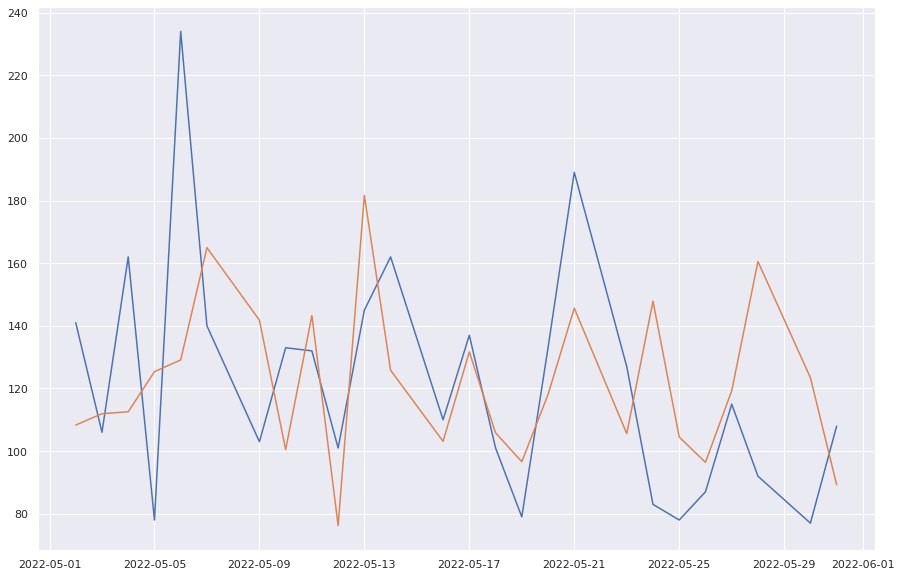

In [ ]:
plt.plot(y_result.index.date, y_result['REAL_ORD_QTY'])
plt.plot(xgb_result.index.date, xgb_result['REAL_ORD_QTY'])